!pip install torch
!pip install torchvision
!pip install torch

In [ ]:
!pip install torchvision==0.18

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls /content/gdrive/MyDrive/concrete
!unrar x "/content/gdrive/MyDrive/concrete/Concrete Crack Images for Classification.rar" "./"

Выходные данные были обрезаны до нескольких последних строк (5000).
Extracting  ./Negative/15002.jpg                                          88%  OK 
Extracting  ./Negative/15003.jpg                                          88%  OK 
Extracting  ./Negative/15004.jpg                                          88%  OK 
Extracting  ./Negative/15005.jpg                                          88%  OK 
Extracting  ./Negative/15006.jpg                                          88%  OK 
Extracting  ./Negative/15007.jpg                                          88%  OK 
Extracting  ./Negative/15008.jpg                                          88%  OK 
Extracting  ./Negative/15009.jpg                                          88%  OK 
Extracting  ./Negative/15010.jpg                                          88%  OK 
Extracting  ./Negative/15011.jpg                                          88%  OK 
Extracting  

In [ ]:
crack_images = os.listdir('Positive/')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  20000


In [ ]:
no_crack_images = os.listdir('Negative/')
print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  20000


*****************Random Images with Cracks**************************


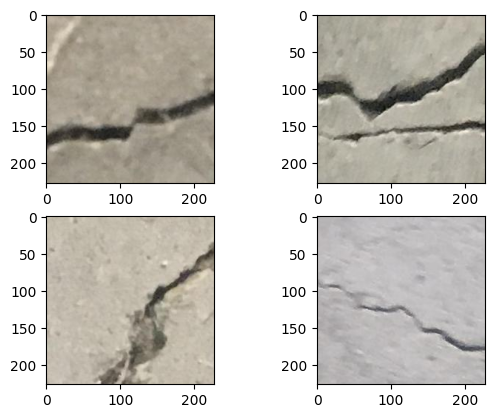

In [ ]:
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[3])))

*****************Random Images without Cracks**************************


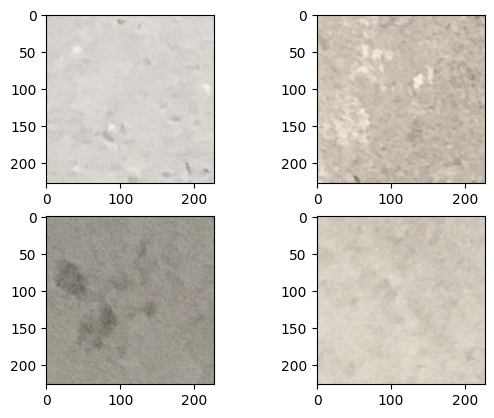

In [ ]:
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[3])))

In [ ]:
base_dir = cwd
files = os.listdir(base_dir)

def create_training_data(folder_name):
    train_dir = f"{base_dir}/train/{folder_name}"
    for f in files:
        search_object = re.search(folder_name, f)
        if search_object:
            shutil.move(f'{base_dir}/{folder_name}', train_dir)

In [ ]:
create_training_data('Positive')
create_training_data('Negative')

Error: Destination path '/content/train/Positive/Positive' already exists

In [ ]:
os.makedirs('val/Positive')
os.makedirs('val/Negative')

FileExistsError: [Errno 17] File exists: 'val/Positive'

In [ ]:
positive_train = base_dir + "/train/Positive/"
positive_val = base_dir + "/val/Positive/"
negative_train = base_dir + "/train/Negative/"
negative_val = base_dir + "/val/Negative/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [ ]:
print(len(positive_files), len(negative_files))

15961 16061


In [ ]:
for f in positive_files:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)

In [ ]:
for f in negative_files:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

# rgb

In [ ]:
import torchvision.transforms

In [ ]:
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  65646
Class Names are:  ['Negative', 'Positive']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([8, 3, 227, 227]) torch.Size([8])


### Visualize the Augmented Data Set

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

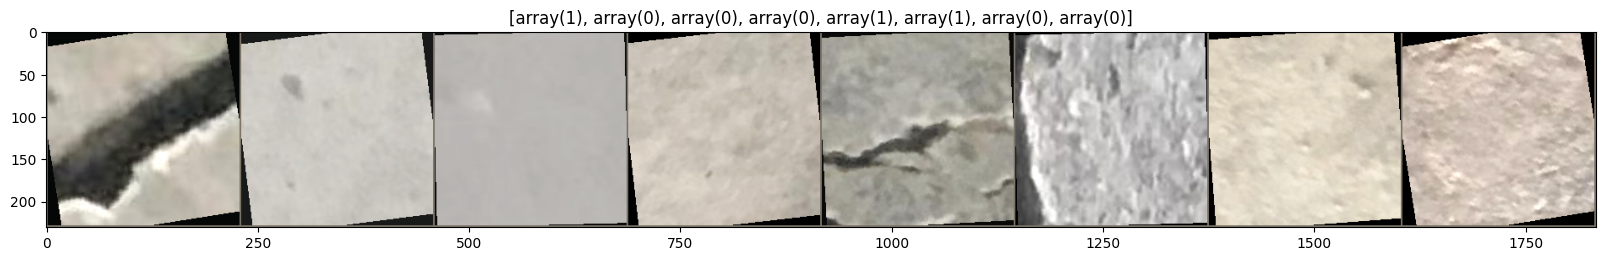

In [ ]:
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

In [ ]:

resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Linear layer is an alias for fully connected layer.
# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 48.8MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            print('Iterating through data...')
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        # minimize model loss and optimize model in this phase
                        optimizer.step()


                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/5
----------
Iterating through data...
train Loss: 0.1508 Acc: 0.9419
Iterating through data...
val Loss: 0.0391 Acc: 0.9873

Epoch 1/5
----------
Iterating through data...
train Loss: 0.1437 Acc: 0.9459
Iterating through data...
val Loss: 0.0356 Acc: 0.9881

Epoch 2/5
----------
Iterating through data...
train Loss: 0.1451 Acc: 0.9441
Iterating through data...
val Loss: 0.0356 Acc: 0.9884

Epoch 3/5
----------
Iterating through data...
train Loss: 0.1427 Acc: 0.9447
Iterating through data...
val Loss: 0.0359 Acc: 0.9883

Epoch 4/5
----------
Iterating through data...
train Loss: 0.1444 Acc: 0.9448
Iterating through data...
val Loss: 0.0361 Acc: 0.9882

Epoch 5/5
----------
Iterating through data...
train Loss: 0.1450 Acc: 0.9444
Iterating through data...
val Loss: 0.0355 Acc: 0.9884

Training complete in 46m 11s
Best val Acc: 0.988435


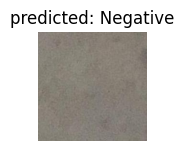

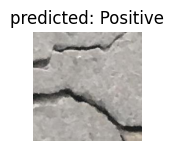

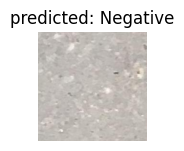

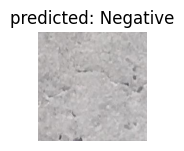

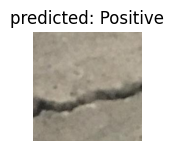

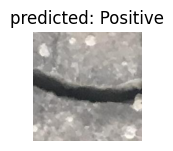

In [ ]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()
torch.save(base_model, '/content/gdrive/MyDrive/mynet_v1.pt')

## Inference

In [ ]:
def predict(model, test_image, print_class = False):
    transform = chosen_transforms['val']

    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)

    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [ ]:
def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            predicted_class = predict(base_model,Image.fromarray(a))
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA)
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

In [ ]:
import urllib

def predict_on_crops_by_url(input_image, height=227, width=227):
    req = urllib.request.urlopen(input_image)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    im = cv2.imdecode(arr, -1)

    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)

    print(predict(base_model, Image.fromarray(im)))

    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            predicted_class = predict(base_model,Image.fromarray(a))
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA)
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    cv2.imwrite(os.path.join('real_images','predictions',  'result.jpg'), output_image)
    return output_image


In [ ]:
plt.figure(figsize=(10,10))
url = 'https://i.pinimg.com/originals/9e/a9/8c/9ea98c0e9fa3ce5efbd7bccd67e73ea2.jpg'
output_image = predict_on_crops_by_url(url, 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [ ]:
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

negative_path = './val/Negative'
positive_path = './val/Positive'

negative_images = os.listdir(negative_path)
positive_images = os.listdir(positive_path)

predicted_labels = []
ground_truth_labels = []

for image in negative_images:
    image_path = os.path.join(negative_path, image)
    predicted_label = predict(base_model, Image.open(image_path))
    predicted_labels.append(predicted_label)
    ground_truth_labels.append('Negative')

for image in positive_images:
    image_path = os.path.join(positive_path, image)
    predicted_label = predict(base_model, Image.open(image_path))
    predicted_labels.append(predicted_label)
    ground_truth_labels.append('Positive')

accuracy = accuracy_score(ground_truth_labels, predicted_labels)
recall = recall_score(ground_truth_labels, predicted_labels, pos_label='Positive')
precision = precision_score(ground_truth_labels, predicted_labels, pos_label='Positive')
f1 = f1_score(ground_truth_labels, predicted_labels, pos_label='Positive')

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1-score:', f1)